In [ ]:
import numpy as np
import os, sys
current_dir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.insert(0, current_dir)
sys.path.insert(0, os.path.join(current_dir, 'conv_gp/'))
from conv_gp.models import ModelBuilder
from argparse import Namespace
import observations

import gpflow

In [ ]:
model_path = './model.npy'
flags = Namespace(
    M='384,384',
    strides='2,1',
    feature_maps='10',
    filter_sizes='4,5',
    batch_size=64,
    base_kernel='rbf',
    last_kernel='conv',
    load_model=model_path,
    identity_mean=False,
    white=False,
    num_samples=5
)

In [ ]:
(Xtrain, Ytrain), (Xtest, Ytest) = observations.cifar10('/tmp/cifar10')
Xtrain = np.transpose(Xtrain, [0, 2, 3, 1]).astype(np.float64)
Xtest = np.transpose(Xtest, [0, 2, 3, 1]).astype(np.float64)
Xtrain /= 255.0
Xtest /= 255.0

std = Xtrain.std(axis=(0, 1, 2))
mean = Xtrain.mean(axis=(0, 1, 2))
Xtrain -= mean
Xtrain /= std
Xtest -= mean
Xtest /= std

builder = ModelBuilder(flags, Xtrain, Ytrain, model_path=flags.load_model)
model = builder.build()

In [4]:
def test_accuracy(noise_level):
    temp_test = (Xtest * std) + mean
    corrupted_test = temp_test + np.random.randn(*Xtest.shape) * noise_level
    corrupted_test = np.where(np.less_equal(corrupted_test, 1.0), corrupted_test, np.ones_like(corrupted_test))
    corrupted_test = np.where(np.greater_equal(corrupted_test, 0.0), corrupted_test, np.zeros_like(corrupted_test))
  
    corrupted_test -= mean
    corrupted_test /= std
    
    correct = 0
    batch_size = 64
    for i in range(len(Ytest) // batch_size + 1):
        batch_slice = slice(i * batch_size, (i+1) * batch_size)
        X = corrupted_test[batch_slice] 
        X += np.random.randn(*X.shape) * noise_level
        Y = Ytest[batch_slice]
        X = X.reshape(X.shape[0], -1) 
        mean_predict, _ = model.predict_y(X, 10)
        class_probs = mean_predict.mean(axis=0)
        predicted = class_probs.argmax(axis=1)
        correct += (predicted == Y).sum()

    accuracy = correct / len(Ytest)
    print("accuracy: {}, noise_level: {}".format(accuracy, noise_level))

In [ ]:
test_accuracy(0.0)
test_accuracy(0.1)
test_accuracy(0.25)
test_accuracy(0.5)
test_accuracy(1.0)

In [5]:
saved_params = np.load(model_path).item()
sess = model.enquire_session()
model_params = {}
for param in model.parameters:
    saved = saved_params[param.pathname]
    value = sess.run(param.constrained_tensor)
    model_params[param.pathname] = value
    print(param.pathname, "diff ", np.linalg.norm(saved - value))

DGP/likelihood/likelihood/invlink/epsilon diff  0.0
DGP/layers/0/conv_kernel/base_kernel/variance diff  0.0
DGP/layers/0/conv_kernel/base_kernel/lengthscales diff  0.0
DGP/layers/0/conv_kernel/base_kernel/variance diff  0.0
DGP/layers/0/conv_kernel/base_kernel/lengthscales diff  0.0
DGP/layers/0/feature/Z diff  0.0
DGP/layers/0/q_mu diff  0.0
DGP/layers/0/q_sqrt diff  0.0
DGP/layers/1/feature/Z diff  0.0
DGP/layers/1/kern/base_kernel/variance diff  0.0
DGP/layers/1/kern/base_kernel/lengthscales diff  0.0
DGP/layers/1/kern/patch_weights diff  0.0
DGP/layers/1/q_mu diff  0.0
DGP/layers/1/q_sqrt diff  0.0


In [19]:
Z = model.layers[0].feature.Z.value

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import umap
sns.set(style="whitegrid", palette='deep')
from kernels import _sample_patches
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
matplotlib.rc('figure', figsize=(11, 6.8))
matplotlib.rc('axes', titlesize=22)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('axes', labelsize=16)

In [20]:
def sample_patches():
    n_patches = Z.shape[0]
    patch_size = 4
    patch_length = patch_size**2 * 3
    patches = np.zeros((n_patches, patch_length))
    for i in range(n_patches):
        random_image = Xtrain[np.random.choice(np.arange(Xtrain.shape[0]))]
        random_patch = _sample_patches(random_image, 1, patch_size, patch_length)
        patches[i, :] = random_patch
    return patches
patches = sample_patches()
Z_and_patches = np.concatenate([patches, Z])

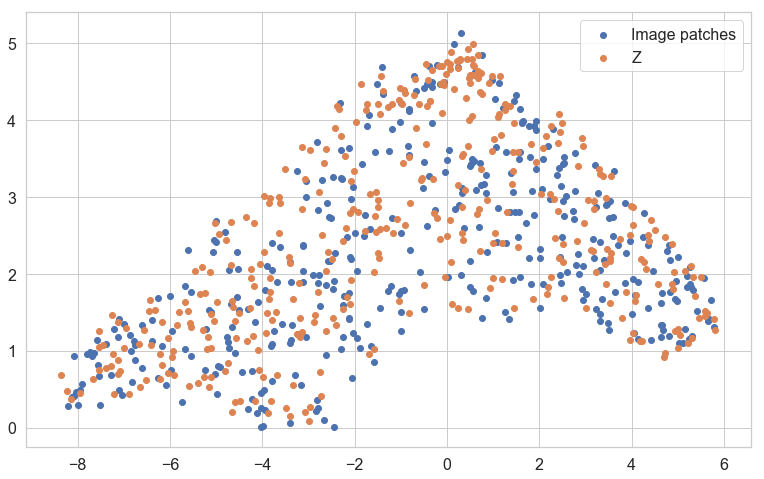

In [23]:
umap_object = umap.UMAP(n_components=2)
umap_object.fit(Z_and_patches)
embedded_Z = umap_object.transform(Z)
embedded_patches = umap_object.transform(patches)
plt.figure(figsize=(13, 8))

plt.scatter(embedded_patches[:, 0], embedded_patches[:, 1], label="Image patches")
plt.scatter(embedded_Z[:, 0], embedded_Z[:, 1], label="Z")
plt.legend();

In [ ]:
from sklearn import manifold

In [ ]:
tsne = manifold.TSNE()
embedded = tsne.fit_transform(Z_and_patches)
embedded_Z = embedded[0:Z.shape[0] // 2]
embedded_patches = embedded[Z.shape[0] // 2:]
plt.scatter(embedded_patches[:, 0], embedded_patches[:, 1], label="Image patches", s=20)
plt.scatter(embedded_Z[:, 0], embedded_Z[:, 1], label="Z", s=20)

plt.legend();

In [ ]:
sns.__version__